<a href="https://colab.research.google.com/github/sobhanshukueian/Denoising-AutoEncoder/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder

Autoencoders are a type of networks that the input is the same as the output. They compress the input into a lower-dimensional code and then reconstruct the output from this representation.

## Denoising AutoEncoders
Autoencoders present an efficient way to learn a representation of your data, which helps with tasks such as dimensionality reduction or feature extraction. You can even train an autoencoder to identify and remove noise from your data.
The purpose of a DAE is to remove noise. You can also think of it as a customised denoising algorithm tuned to your data.

![image](https://miro.medium.com/max/828/1*iXCORmu7vWolNrcqCTMB0A.png)

[More](https://towardsdatascience.com/denoising-autoencoders-dae-how-to-use-neural-networks-to-clean-up-your-data-cd9c19bc6915)

# Dependencies

In [ ]:
# %matplotlib inline
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import os
import shutil
import matplotlib
# matplotlib.use("TKAgg")
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 128


# Dataset
The MNIST database of handwritten digits has a training set of 60,000 examples and a test set of 10,000 samples.
I used pytorch datasets for downloading dataset : 
```
train_dataset = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist/', train=False, download=True, transform=transform)
```

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(
    'mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(
    'mnist/', train=False, download=True, transform=transform)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Model

The critical components of Autoencoders are:

* **Input layer** — to pass input data into the network
* **Hidden layer** consisting of Encoder and Decoder — to process information by applying weights, * biases and activation functions
* **Output layer** — typically matches the input neurons

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# Train
Trainer class Does the main part of code which is training model, plot the training process and save model each n epochs.

I Defined `Adam` Optimizer with learning rate 0.0002.

In ```add_noise``` randomly add gaussian and uniform noise with below configs to image: 
* {"type":"gaussian", "mean":0, "var":0.1},
* {"type":"gaussian", "mean":0, "var":0.2},
* {"type":"gaussian", "mean":0, "var":0.3},
* {"type":"gaussian", "mean":0, "var":0.4},
* {"type":"gaussian", "mean":0, "var":0.05},
* {"type":"gaussian", "mean":0, "var":0.01},
* {"type":"uniform", "min":-0.01, "max":0.01},
* {"type":"uniform", "min":-0.1, "max":0.1},
* {"type":"uniform", "min":-0.2, "max":0.2}, 

## Some Configurations
 
*   You can set epoch size : `EPOCHS` and batch size : `BATCH_SIZE`.
*   Set `device` that you want to train model on it : `device`(default runs on cuda if it's available)
*   You can set one of three `verboses` that prints info you want => 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters size.
*   Each time you train model weights and plot(if `save_plots` == True) will be saved in `save_dir`.
*   You can find a `configs` file in `save_dir` that contains some information about run. 
*   You can choose Optimizer: `OPTIMIZER` 

In [ ]:
#@title Some Configurations
EPOCHS = 200 #@param {type:"integer"}
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu' #@param
VERBOSE = 3 #@param [0, 1, 2, 3] {type:"raw"}
SAVE_PLOTS = True #@param {type:"boolean"}
VISUALIZE_PLOTS = True #@param {type:"boolean"}
SAVE_DIR = "./runs" #@param
MODEL_NAME = "Denoising AutoEncoder" #@param
OPTIMIZER = "Adam" #@param ["Adam", "SGD"] {type:"raw"}
WEIGHTS = None

Encoder Model: Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
Decoder Model: Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0)

Epoch: 0/500 Loss: 1.652232748867352: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s]


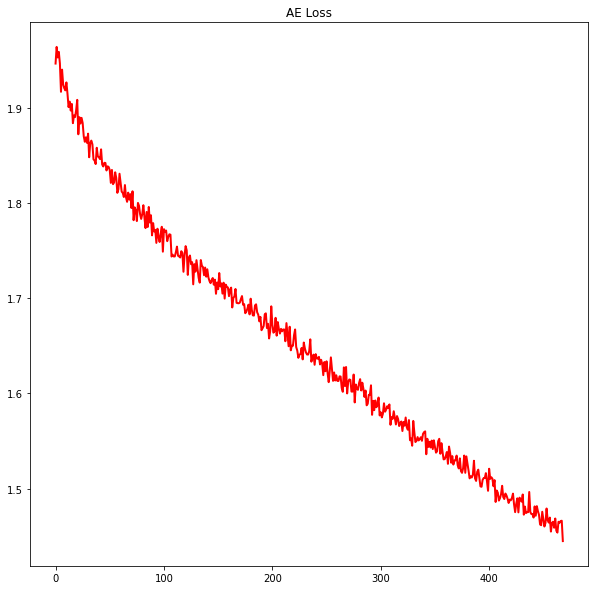

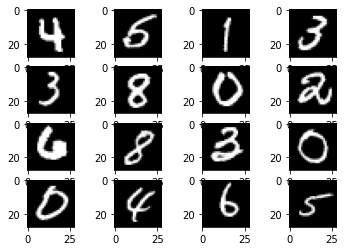

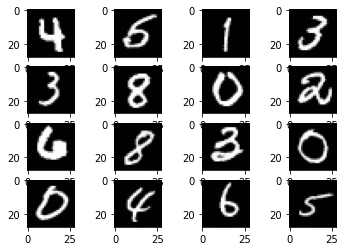

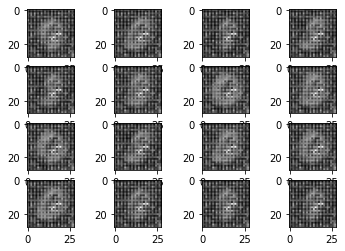

Epoch: 10/500 Loss: 0.9030898133320595: 100%|██████████| 469/469 [00:35<00:00, 13.29it/s]


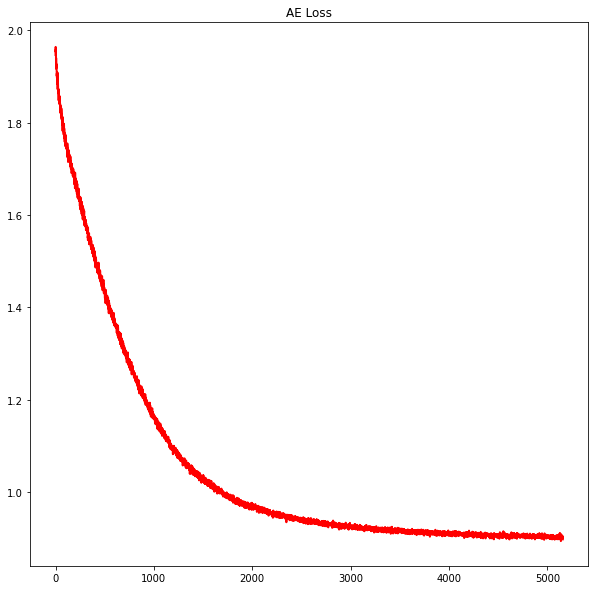

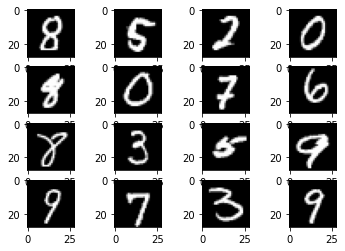

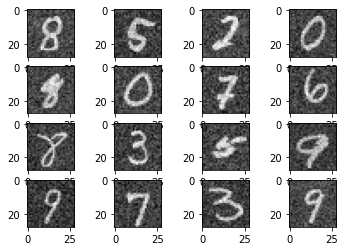

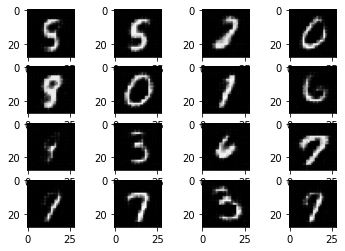

Epoch: 20/500 Loss: 0.8881489739997555: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]


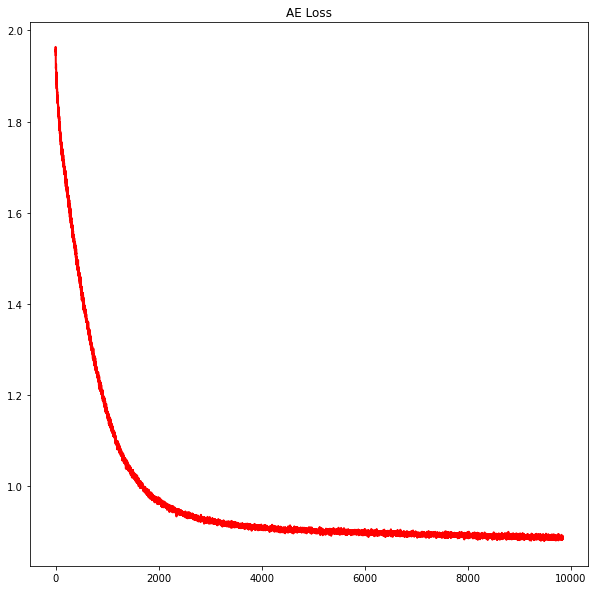

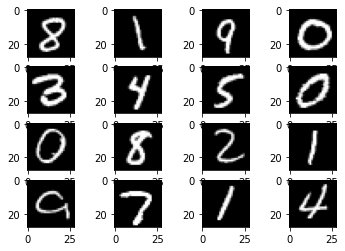

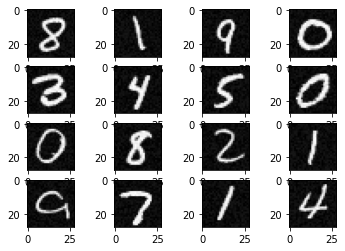

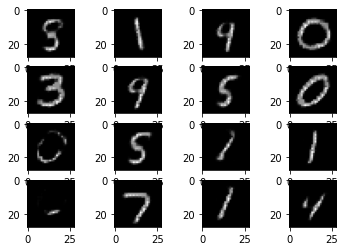

Epoch: 30/500 Loss: 0.8818070738554509: 100%|██████████| 469/469 [00:40<00:00, 11.72it/s]


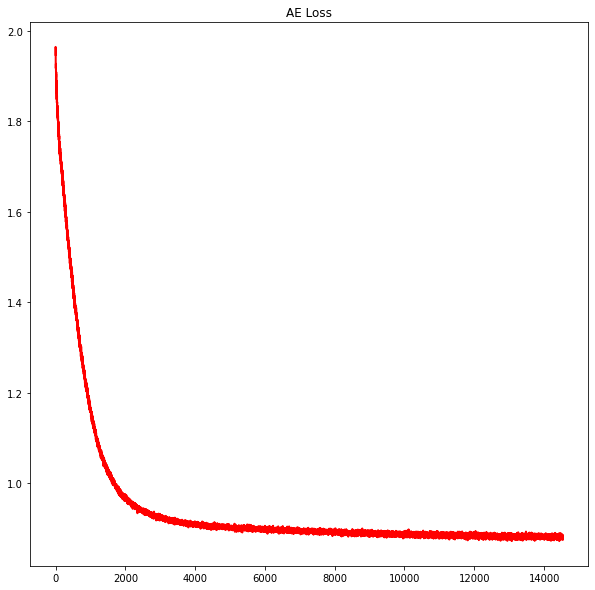

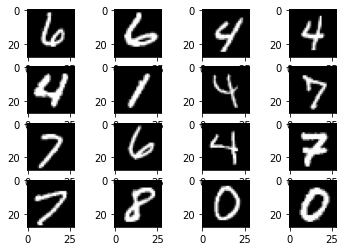

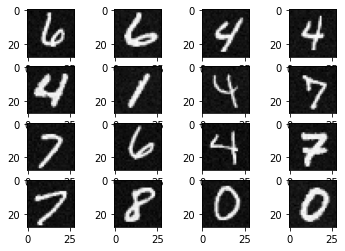

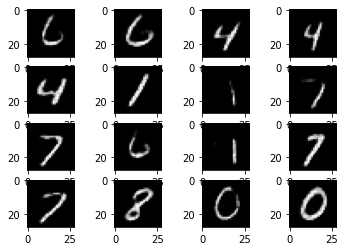

Epoch: 40/500 Loss: 0.8798340112924068: 100%|██████████| 469/469 [00:33<00:00, 13.86it/s]


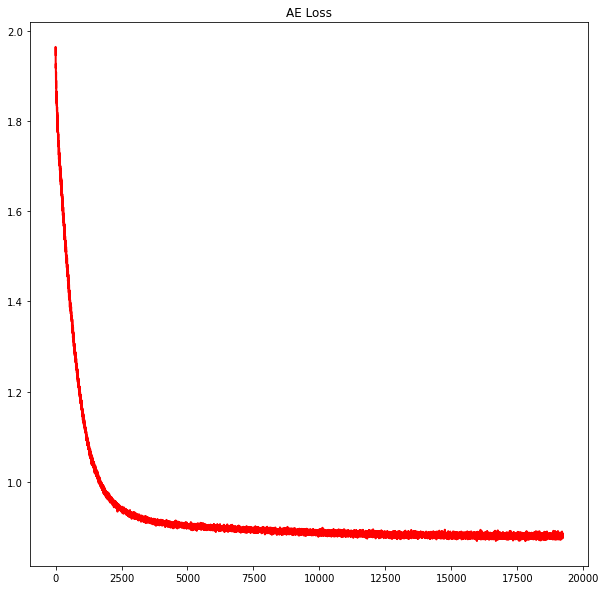

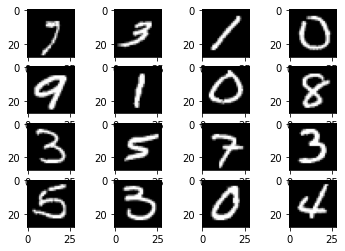

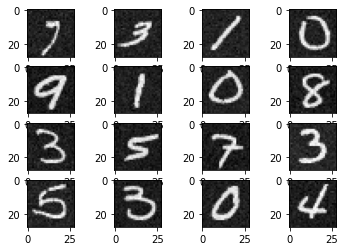

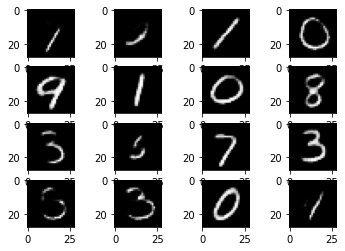

Epoch: 43/500 Loss: 0.8794562645933844:  94%|█████████▍| 440/469 [00:34<00:02, 12.85it/s]


KeyboardInterrupt: ignored

In [ ]:
import os
import time
import math
from copy import deepcopy
import os.path as osp
import shutil
from prettytable import PrettyTable
import json

from tqdm import tqdm

import numpy as np
import torch
from torch.cuda import amp
# from torch.utils.tensorboard import SummaryWriter

class Trainer:
    # -----------------------------------------------INITIALIZE TRAINING-------------------------------------------------------------
    def __init__(self, device=DEVICE, epochs=EPOCHS, batch_size=BATCH_SIZE, save_dir=SAVE_DIR, train_loader=train_dataloader, valid_loader=test_dataloader, weights=WEIGHTS, verbose=VERBOSE, visualize_plots=True, save_plots=True, model_name=MODEL_NAME):
        self.device = device
        self.save_dir = save_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_ema = False
        self.model_name = "MNIST Denoising usein autoencoder"
        self.weights = weights
        self.visualize_plots = visualize_plots
        self.save_plots = save_plots
        # 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters
        self.verbose = verbose
        self.losses=[]
        self.conf = {'Name' : self.model_name, 'Bacth_size' : self.batch_size, 'Max_iter_num' : '', 'Epochs' : self.epochs, 'Trained_epoch' : 0, 'Optimizer' : '', "Model" : '', 'Parameter_size' : ''}

        temm=0
        tmp_save_dir = self.save_dir
        while osp.exists(tmp_save_dir):
            tmp_save_dir = self.save_dir
            temm+=1
            tmp_save_dir += (str(temm))
        self.save_dir = tmp_save_dir
        del temm


        # get data loader
        self.train_loader, self.valid_loader = train_loader, valid_loader
        self.max_stepnum = len(self.train_loader)
        self.conf["Max_iter_num"] = self.max_stepnum
        
        # get model 
        self.e_model, self.d_model = self.get_model()
        if self.verbose > 2:
            self.count_parameters(self.e_model)
            self.count_parameters(self.d_model)
 
        # Get optimizer
        self.optimizer = self.get_optimizer()
    
# ----------------------------------------------------INITIALIZERS-------------------------------------------------------------------------
    # Get Model 
    def get_model(self):
        # Get Model Archutecture From Model Class.
        e_model = Encoder(encoded_space_dim=4, fc2_input_dim=128).to(self.device)
        d_model = Decoder(encoded_space_dim=4,fc2_input_dim=128).to(self.device)

        # Log Model
        if self.verbose > 0:
            print('Encoder Model: {}\nDecoder Model: {}'.format(e_model, d_model))
        self.conf["Encoder Model"] = str(e_model)
        self.conf["Decoder Model"] = str(d_model)
        return e_model, d_model

    def get_optimizer(self, optimizer="Adam", lr0=0.0002, beta1 = 0.5):
        params_to_optimize = [
            {'params': self.e_model.parameters()},
            {'params': self.d_model.parameters()}
        ]
        assert optimizer == 'SGD' or 'Adam', 'ERROR: unknown optimizer, use SGD defaulted'
        if optimizer == 'SGD':
            optim = torch.optim.SGD(params_to_optimize, lr=lr0, momentum=0.5)
        elif optimizer == 'Adam':
            optim = torch.optim.Adam(params_to_optimize, lr=lr0, betas=(beta1, 0.999))

        if self.verbose > 1:
            print(f"{'Optimizer:'} {type(optim).__name__}")

        self.conf['Optimizer'] = f"{'Optimizer:'} {type(optim).__name__}"
        return optim

    def count_parameters(self, model):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in model.named_parameters():
            if not parameter.requires_grad: continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        self.conf["Parameter_size"] = total_params

    def compute_loss(self, inputs, noisy_inputs):
        criteria = torch.nn.MSELoss() 
        loss = criteria(inputs, noisy_inputs)
        return loss

    @staticmethod
    def add_noise(inputs):
        noise_setups = [
            {"type":"gaussian", "mean":0, "var":0.1},
            {"type":"gaussian", "mean":0, "var":0.2},
            {"type":"gaussian", "mean":0, "var":0.3},
            {"type":"gaussian", "mean":0, "var":0.4},
            {"type":"gaussian", "mean":0, "var":0.05},
            {"type":"gaussian", "mean":0, "var":0.01},
            {"type":"uniform", "min":-0.01, "max":0.01},
            {"type":"uniform", "min":-0.1, "max":0.1},
            {"type":"uniform", "min":-0.2, "max":0.2},
            # {"type":"snp", "p_salt":0.005, "p_pepper":0.005},
            # {"type":"snp", "p_salt":0.01, "p_pepper":0.01},
            # {"type":"snp", "p_salt":0.02, "p_pepper":0.02}
        ]
        noise_setup = noise_setups[np.random.randint(0, len(noise_setups))]
        # print(noise_setup)
        if noise_setup["type"] == "gaussian":
            noise = torch.normal(mean=noise_setup["mean"], std=noise_setup["var"], size=inputs.shape)
            noise = noise.to(self.device)
        elif noise_setup["type"] == "uniform":
            noise = (noise_setup["max"] - noise_setup["min"]) * torch.rand(inputs.shape) + noise_setup["max"]
            noise = noise.to(self.device)
        # else: # noise_setup["type"] == "snp":
        #     noise = torch.normal(mean=noise_setup["mean"], std=noise_setup["var"], size=inputs.shape)
        #     noise = noise.to(device)
        noisy = inputs + noise
        return noisy
# -------------------------------------------------------------------------------TRAINING PROCESS-----------------------------------------------
    def train_step(self, batch_data):
        inputs = batch_data[0].to(self. device)
        noisy_inputs = self.add_noise(inputs).to(self.device)
        
        encoded_inputs = self.e_model(noisy_inputs)
        decoded_inputs = self.d_model(encoded_inputs)

        # Zero the parameter gradients
        self.optimizer.zero_grad()

        # Backward propagation
        loss = self.compute_loss(decoded_inputs, inputs)
        loss.backward()
        self.optimizer.step()
        return loss.item(), decoded_inputs, noisy_inputs, inputs
        
    # Training Process
    def train(self):
        try:
            # training process prerequisite
            self.start_time = time.time()
            print('Start Training Process \nTime: {}'.format(time.ctime(self.start_time)))

            # Epoch Loop
            for self.epoch in range(0, self.epochs):
                try:
                    self.conf["Trained_epoch"] = self.epoch
                    # Training loop
                    self.e_model.train(True)
                    self.d_model.train(True)

                    pbar = enumerate(self.train_loader)
                    pbar = tqdm(pbar, total=self.max_stepnum)
                    each_epoch_loss = []

                    for step, batch_data in pbar:
                        loss, decoded_images, noisy_images, inputs = self.train_step(batch_data)
                        each_epoch_loss.append(loss)
                        self.losses.append(loss)
                        pbar.set_description(f"Epoch: {self.epoch}/{self.epochs} Loss: {np.mean(each_epoch_loss)}")
                    del pbar

                except Exception as _:
                    print('ERROR in training steps.')
                    raise
                if self.epoch % 10 == 0:
                    # PLot Losses
                    self.plot_loss()
                    imgs_numpy = (inputs.data.cpu().numpy()+1.0)/2.0
                    # show_images(imgs_numpy[:16])
                    sqrtn = int(np.ceil(np.sqrt(imgs_numpy[:16].shape[0])))
                    for index, image in enumerate(imgs_numpy[:16]):
                        plt.subplot(sqrtn, sqrtn, index+1)
                        plt.imshow(image.reshape(28, 28), cmap='gray')
                    imgs_numpy = (decoded_images.data.cpu().numpy()+1.0)/2.0
                    save_img_dir = osp.join(self.save_dir, 'images') 
                    if not osp.exists(save_img_dir):
                        os.makedirs(save_img_dir)
                    plt.savefig("{}/epoch-{}-inputs-img.png".format(save_img_dir, self.epoch)) 
                    plt.show()
                    imgs_numpy = (noisy_images.data.cpu().numpy()+1.0)/2.0
                    # show_images(imgs_numpy[:16])
                    sqrtn = int(np.ceil(np.sqrt(imgs_numpy[:16].shape[0])))
                    for index, image in enumerate(imgs_numpy[:16]):
                        plt.subplot(sqrtn, sqrtn, index+1)
                        plt.imshow(image.reshape(28, 28), cmap='gray')
                    imgs_numpy = (decoded_images.data.cpu().numpy()+1.0)/2.0
                    save_img_dir = osp.join(self.save_dir, 'images') 
                    if not osp.exists(save_img_dir):
                        os.makedirs(save_img_dir)
                    plt.savefig("{}/epoch-{}-noisy-img.png".format(save_img_dir, self.epoch)) 
                    plt.show()
                    sqrtn = int(np.ceil(np.sqrt(imgs_numpy[:16].shape[0])))
                    for index, image in enumerate(imgs_numpy[:16]):
                        plt.subplot(sqrtn, sqrtn, index+1)
                        plt.imshow(image.reshape(28, 28), cmap='gray')
                    save_img_dir = osp.join(self.save_dir, 'images') 
                    if not osp.exists(save_img_dir):
                        os.makedirs(save_img_dir)
                    plt.savefig("{}/epoch-{}-img.png".format(save_img_dir, self.epoch)) 
                    plt.show()
                    
        except Exception as _:
            print('ERROR in training loop or eval/save model.')
            raise
        finally:
            finish_time = time.time()
            # print(f'\nTraining completed in {time.ctime(finish_time)} \nIts Done in: {(time.time() - self.start_time) / 3600:.3f} hours.') 
    

    # -------------------------------------------------------Training Callback after each epoch--------------------------
    def plot_loss(self, train_mean_size=1, val_mean_size=1):
        COLS=1
        ROWS=1
        LINE_WIDTH = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))

        # train_mean_size = self.max_stepnum/self.batch_size

        ax.plot(np.arange(len(self.losses) / train_mean_size), np.mean(np.array(self.losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax.set_title("AE Loss")
        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-loss-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()

Trainer().train()

